In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Optional, Union, Tuple, List
from sklearn.model_selection import train_test_split

# Functions

In [36]:
def split_data_by_date(
    df: pd.DataFrame,
    date_col: str,
    train_start_date: str,
    train_end_date: str,
    test_start_date: str,
    test_end_date: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits data into train, test and validation datasets using a date reference column.
    """

    # filter data for train and test datasets
    train = df[(df[date_col] >= train_start_date) & (df[date_col] <= train_end_date)].reset_index(drop=True)
    test = df[(df[date_col] >= test_start_date) & (df[date_col] <= test_end_date)].reset_index(drop=True)

    return train, test

def null_and_unique_info(df: pd.DataFrame) -> pd.DataFrame:
    """
    Completes information about the dataframe columns, including unique values and null values.
    """

    df_list = []
    for col in df.columns:
        info_df = pd.DataFrame(
            {col: [
                df[col].nunique(), df[col].isnull().sum()]}, index=['unique_values', 'null_values'])
        df_list.append(info_df)

    return pd.concat(df_list, axis=1)

# use unittest to test the function
def test_null_and_unique_info():
    """
    Unit test for complete_info function.
    """

    # create a dataframe with different types of columns
    df = pd.DataFrame({
        'col1': [1, 2, 3, 4, 5, np.nan],
        'col2': ['a', 'b', 'c', 'd', 'e', None],
        'col3': [1., 1., 1., 1., 1., 2.0],
        'col4': [pd.NaT, pd.Timestamp('2021-01-01'), pd.Timestamp('2021-01-02'), pd.Timestamp('2021-01-03'), pd.Timestamp('2021-01-04'), pd.Timestamp('2021-01-05')]
    })

    # run the function
    result = null_and_unique_info(df)

    # define the expected result
    expected = pd.DataFrame({
        'col1': [5, 1],
        'col2': [5, 1],
        'col3': [2, 0],
        'col4': [5, 1]
    }, index=['unique_values', 'null_values'])

    # assert the result
    pd.testing.assert_frame_equal(result, expected)


test_null_and_unique_info()
    

# Data Ingestion and Split

In [37]:
df = pd.read_csv('nicolas_ds_20240201.gzip', compression='gzip')

## Fast check on data type and values

In [38]:
df.dtypes

fake_cnpj                                             int64
date_reference                                       object
general_lost_pct_risco                              float64
years_since_first_relationship                      float64
chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo    float64
days_since_oldest_board_member                      float64
v001r_social_capital                                float64
cnt_declined_reasons                                  int64
chk_esp_cred_rot_a_vencer_pct_risco                 float64
general_limite_de_cred_sum_pct_risco                float64
general_limite_de_cred_sum                          float64
general_a_vencer_weighted_periodo_div_pct_risco     float64
avg_final_numeric_prediction_prev_6mo               float64
is_not_able_to_calc_interest                          int64
min_lt_ir3_prev_6mo                                 float64
general_limite_de_cred_360m_sum                     float64
v204r_is_popular_domain                 

In [39]:
#transform object column to datetime
df['date_reference'] = pd.to_datetime(df['date_reference'], format='%Y-%m-%d')

In [40]:
# checking the number of CNPJs available to model and number of entries per CNPJ
df['fake_cnpj'].nunique(), df.shape[0]/df['fake_cnpj'].nunique()

(30646, 7.616132611107486)

In [41]:
# Summary of column values
summary = pd.concat([df.describe(), null_and_unique_info(df)], axis=0)
summary

,fake_cnpj,date_reference,general_lost_pct_risco,years_since_first_relationship,chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,days_since_oldest_board_member,v001r_social_capital,cnt_declined_reasons,chk_esp_cred_rot_a_vencer_pct_risco,general_limite_de_cred_sum_pct_risco,...,general_a_vencer_under30d,general_vencido_sum_sum_pct_risco,general_prejuizo_sum_pct_risco,general_lost_pct_cart_cred,general_a_vencer_under180d,general_a_vencer_over180d,general_vencido_max_prev_6mo,general_vencido_pct_risco_max_prev_6mo,general_vencido_pct_carteira_cred__max_prev_6mo,TARGET_default_within_11m
count,233404.000000,233404,233404.000000,233404.000000,233404.000000,233404.000000,2.334040e+05,233404.000000,233404.000000,233404.000000,...,2.334040e+05,233404.000000,233404.000000,233404.000000,2.334040e+05,2.334040e+05,2.334040e+05,233404.000000,233404.000000,233404.000000
mean,33208.241487,2022-03-31 04:45:46.811537408,0.002995,8.070530,0.084195,6.524040,1.022799e+07,0.128263,0.037168,0.315439,...,7.203692e+05,0.002902,0.000093,0.003406,4.549017e+06,2.377831e+06,2.548038e+04,0.023178,0.029901,0.135083
min,12.000000,2020-09-01 00:00:00,0.000000,-0.082192,0.000000,-1.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,11552.000000,2021-11-01 00:00:00,0.000000,1.917808,0.000000,1.172603,1.000000e+04,0.000000,0.000000,0.042802,...,1.851277e+03,0.000000,0.000000,0.000000,9.021130e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,26231.000000,2022-06-01 00:00:00,0.000000,4.506849,0.003561,3.641096,7.240000e+04,0.000000,0.000000,0.193011,...,8.562990e+03,0.000000,0.000000,0.000000,5.096530e+04,3.107044e+04,0.000000e+00,0.000000,0.000000,0.000000
75%,44302.000000,2022-10-01 00:00:00,0.000000,11.016438,0.064216,9.257534,1.560000e+05,0.000000,0.007541,0.537981,...,5.123542e+04,0.000000,0.000000,0.000000,2.729334e+05,2.256255e+05,0.000000e+00,0.000000,0.000000,0.000000
max,116371.000000,2023-07-01 00:00:00,0.100000,64.967123,1.000000,70.093151,3.218350e+10,2.000000,1.000000,0.999965,...,2.367276e+09,0.100000,0.099911,0.990438,1.055517e+10,2.870458e+09,1.217688e+08,1.000000,1.000000,1.000000
std,28812.566706,NaN,0.012784,9.156076,0.190039,8.292561,3.343273e+08,0.347083,0.129130,0.318171,...,1.517714e+07,0.012547,0.002265,0.016034,8.702245e+07,2.608751e+07,5.825340e+05,0.104182,0.125258,0.341813
unique_values,30646.000000,35,23384.000000,14981.000000,53440.000000,14216.000000,2.580000e+03,3.000000,104379.000000,212113.000000,...,2.055480e+05,22660.000000,1068.000000,23382.000000,2.277610e+05,1.475160e+05,1.890700e+04,19360.000000,19172.000000,2.000000
null_values,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000


In [42]:
# get the first occurrence of each CNPJ given the date_reference

# Train, Test, Validation Split

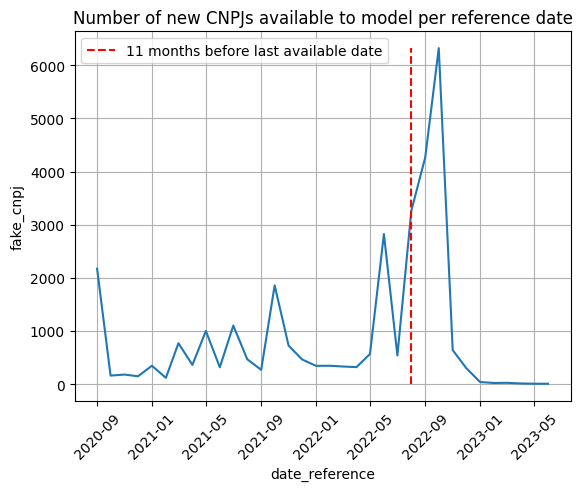

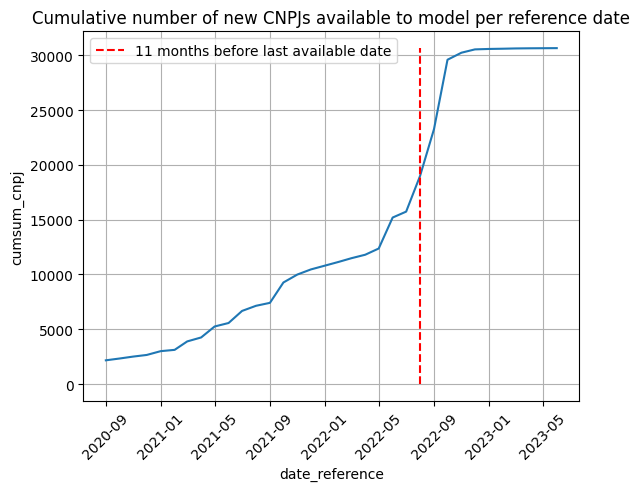

In [43]:
# ids outside modeling dataset - these CNPJs haven't tenured 11 months yet, therefore, 
# we may observe default but is hard to identify the cases where the default hadn't happened 
# yet but will happen in 11 months

last_date_minus_11m = df['date_reference'].max() - pd.DateOffset(months=11)
plot_df = df.groupby('fake_cnpj')['date_reference'].min().reset_index().groupby('date_reference').agg({'fake_cnpj': 'nunique'}).reset_index()
sns.lineplot(data=plot_df, x='date_reference', y='fake_cnpj')
plt.xticks(rotation=45)
plt.title('Number of new CNPJs available to model per reference date')
plt.grid()
plt.vlines(last_date_minus_11m, colors='r', linestyles='dashed', ymax=plot_df['fake_cnpj'].max(), ymin=0, label='11 months before last available date')
plt.legend()
plt.show()


plot_df['cumsum_cnpj'] = plot_df['fake_cnpj'].cumsum()
sns.lineplot(data=plot_df, x='date_reference', y='cumsum_cnpj')
plt.xticks(rotation=45)
plt.title('Cumulative number of new CNPJs available to model per reference date')
plt.grid()
plt.vlines(last_date_minus_11m, colors='r', linestyles='dashed', ymax=plot_df['cumsum_cnpj'].max(), ymin=0, label='11 months before last available date')
plt.legend()
plt.show()

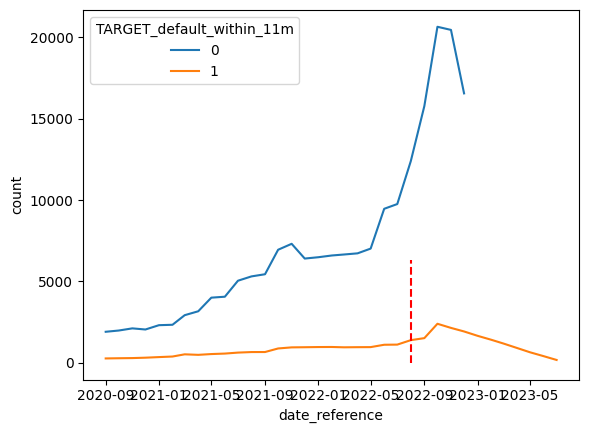

In [44]:
sns.lineplot(df.groupby('date_reference')['TARGET_default_within_11m'].value_counts().reset_index(), x='date_reference', y='count', hue='TARGET_default_within_11m')
plt.vlines(last_date_minus_11m, colors='r', linestyles='dashed', ymax=plot_df['fake_cnpj'].max(), ymin=0, label='11 months before last available date')
plt.show()

In [45]:
plot_df

,date_reference,fake_cnpj,cumsum_cnpj
0,2020-09-01,2173,2173
1,2020-10-01,161,2334
2,2020-11-01,180,2514
3,2020-12-01,148,2662
4,2021-01-01,346,3008
5,2021-02-01,118,3126
6,2021-03-01,770,3896
7,2021-04-01,362,4258
8,2021-05-01,1000,5258
9,2021-06-01,317,5575


In [46]:
scoring_only = df[df['date_reference'] >= last_date_minus_11m]
modeling_df = df[df['date_reference'] < last_date_minus_11m]

In [47]:
len([id for id in scoring_only['fake_cnpj'].unique() if id not in modeling_df['fake_cnpj']])

11492

In [48]:
# Defining the datasets frontiers
train_end_quantile, test_end_quantile = 0.4, 0.7

train_end_date, test_end_date = (
    plot_df[plot_df['date_reference'] < last_date_minus_11m]
    .quantile([train_end_quantile, test_end_quantile])['date_reference']
    .values
    )
    
train_start_date = modeling_df['date_reference'].min().strftime('%Y-%m-%d')
train_end_date = pd.to_datetime(train_end_date).strftime('%Y-%m-%d')
test_start_date = (pd.to_datetime(train_end_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
test_end_date = pd.to_datetime(test_end_date).strftime('%Y-%m-%d')
valid_start_date = (pd.to_datetime(test_end_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

train, test = split_data_by_date(
    df=modeling_df, 
    date_col='date_reference',
    train_start_date=train_start_date,
    train_end_date=train_end_date,
    test_start_date=test_start_date,
    test_end_date=test_end_date
    )
valid = modeling_df[(modeling_df['date_reference'] >= valid_start_date)].reset_index(drop=True)

train_ids = train['fake_cnpj'].unique()
test_ids = [id for id in test['fake_cnpj'].unique() if id not in train_ids]
valid_ids = [id for id in valid['fake_cnpj'].unique() if id not in train_ids and id not in test_ids]

train = train[train['fake_cnpj'].isin(train_ids)]
test = test[test['fake_cnpj'].isin(test_ids)]
valid = valid[valid['fake_cnpj'].isin(valid_ids)]

In [49]:
# selecting a single random row for each CNPJ for training set
train = train.groupby('fake_cnpj').sample(1, random_state=42)
train['fake_cnpj'].nunique(), train['fake_cnpj'].count()

(5258, 5258)

In [50]:
# datasets sizes
train['fake_cnpj'].nunique(), test['fake_cnpj'].nunique(), valid['fake_cnpj'].nunique()

(5258, 5203, 5273)

In [51]:
excluded_ids = [id for id in modeling_df['fake_cnpj'].unique() if id not in train_ids and id not in test_ids and id not in valid_ids]
print(f"IDs out of sample, out of space inside modeling_df: {len(modeling_df[modeling_df['fake_cnpj'].isin(excluded_ids)]['fake_cnpj'].unique())}")

IDs out of sample, out of space inside modeling_df: 0


In [52]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
valid.to_csv('valid.csv', index=False)